This example constructs a pipeline that does dimensionality reduction followed by prediction with a support vector classifier. It demonstrates the use of GridSearchCV and Pipeline to optimize over different classes of estimators in a single CV run.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC


In [3]:
# load dataset
X, y = load_digits(return_X_y=True)
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [4]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [5]:
# create pipeline
pipe = Pipeline(
    [
        ("scaling", MinMaxScaler()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("classify", LinearSVC(dual=False, max_iter=10000)),
    ]
)

In [6]:
N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        "reduce_dim": [PCA(iterated_power=7)],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
]
reducer_labels = ["PCA"]

In [7]:
grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
grid.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('scaling', MinMaxScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        LinearSVC(dual=False,
                                                  max_iter=10000))]),
             n_jobs=1,
             param_grid=[{'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [PCA(iterated_power=7)],
                          'reduce_dim__n_components': [2, 4, 8]}])

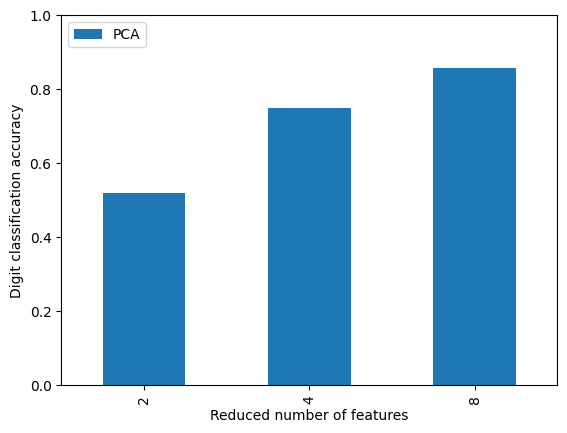

In [9]:
import pandas as pd

mean_scores = np.array(grid.cv_results_["mean_test_score"])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
# create a dataframe to ease plotting
mean_scores = pd.DataFrame(
    mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
)

ax = mean_scores.plot.bar()
ax.set_xlabel("Reduced number of features")
ax.set_ylabel("Digit classification accuracy")
ax.set_ylim((0, 1))
ax.legend(loc="upper left")

plt.show()